# Deep Bidirectional Neural Network (GRU)

In [1]:
! nvidia-smi

Fri May 26 09:36:05 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.72       Driver Version: 512.72       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   56C    P8     3W /  N/A |      1MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 1. General Settings
Install some necessary libraries and download processed data for model training and evaluation

In [ ]:
!git clone https://github.com/helloitsurdvq/StockReview.IntroAI.20222.git

In [ ]:
%ls StockReview.IntroAI.20222/source/data/

In [ ]:
%cd StockReview.IntroAI.20222/

In [ ]:
%cd source/

## 2. Import Libraries

In [14]:
import os

import numpy as np
import pandas as pd

import sklearn
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import sklearn.preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')

import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras import layers

In [4]:
# Seed to reproduce results
np.random.seed(0)
tf.random.set_seed(0)

## 3. Data Preparation
In this section, we will load the dataset from the converted data and prepare for model training

In [5]:
train_df = pd.read_json('data/stock_train.json')
test_df = pd.read_json('data/stock_test.json')

In [6]:
train_df

,text,label,label_id
0,"Tại thị trường trong nước, khảo sát lúc 9 giờ ...",positive,0
1,tăng 50.000 đồng/lượng ở cả hai chiều mua và b...,positive,0
2,Tại 2 thị trường lớn khác là Hà Nội và Đà Nẵng...,positive,0
3,Vàng lại bật tăng vượt ngưỡng 2.000 USD/ounce,positive,0
4,tăng 24 USD/ounce so với cùng giờ sáng qua,positive,0
...,...,...,...
1511,Danh mục đầu tư 60/40 là mô hình phân chia tài...,neutral,2
1512,"Theo tính toán của Vanguard, lợi nhuận hàng nă...",neutral,2
1513,Nhóm chuyên gia JP Morgan xem xét 200 loại tài...,neutral,2
1514,Kết luận đưa ra là các nguyên tắc cốt lõi của ...,neutral,2


In [7]:
test_df

,text,label,label_id
0,Tại 2 thị trường lớn khác là Hà Nội và Đà Nẵng...,positive,0
1,"Như vậy, trong 2 ngày qua, giá vàng nhẫn đã tă...",positive,0
2,"Giá vàng thế giới bật tăng trở lại, khi lực cầ...",positive,0
3,"Tại thị trường thế giới, thời điểm lúc 9 giờ 3...",positive,0
4,"Tuy nhiên, sau đó lực cầu bắt đáy mạnh đã giúp...",positive,0
...,...,...,...
997,"Ngoài 47 triệu cổ phiếu khớp lệnh, HAG còn ghi...",neutral,2
998,báo cáo giải trình của SHS cho biết,neutral,2
999,"Cuối quý I, SHS nắm giữ 2.240 tỷ đồng cổ phiếu...",neutral,2
1000,SHS còn nắm giữ hơn 420 tỷ đồng TCB với giá tr...,neutral,2


In [8]:
# Label One-Hot-Encoding
label_encoded = sklearn.preprocessing.OneHotEncoder(sparse=False).fit_transform(pd.DataFrame([*list(train_df.label_id), *list(test_df.label_id)]))

c:\Users\DELL\Programming\python\StockReview.IntroAI.20222\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [9]:
# Create TensorFlow Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_df.text, label_encoded[:len(train_df)]))
test_dataset = tf.data.Dataset.from_tensor_slices((test_df.text, label_encoded[len(train_df):]))

# Batches
BUFFER_SIZE = 10000
BATCH_SIZE = 128

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
    print(len(example))
    print('Texts: ', example.numpy()[:1])
    print('Labels: ', label.numpy()[:1])

128
Texts:  [b'V\xe1\xbb\x9bi vi\xe1\xbb\x87c \xc4\x91\xc6\xb0a s\xe1\xbb\x9f h\xe1\xbb\xafu v\xe1\xbb\x81 d\xc6\xb0\xe1\xbb\x9bi ng\xc6\xb0\xe1\xbb\xa1ng 5%, SMBC kh\xc3\xb4ng c\xe1\xba\xa7n c\xc3\xb4ng b\xe1\xbb\x91 th\xc3\xb4ng tin nh\xe1\xbb\xafng l\xe1\xba\xa7n giao d\xe1\xbb\x8bch sau \xc4\x91\xc3\xb3']
Labels:  [[0. 0. 1.]]


### Encoder

In [10]:
# Encoder Vocab Size
VOCAB_SIZE = 10000

# Encoder
encoder = layers.TextVectorization(VOCAB_SIZE)

# Adapt TextVectorization for Train text to sets the layer's vocabulary
encoder.adapt(train_dataset.map(lambda text, label: text))

# Vocab
print(f"Vocab_size: {len(encoder.get_vocabulary())}")
encoder.get_vocabulary()[:10]

Vocab_size: 2279


['', '[UNK]', 'và', 'trong', 'tăng', 'với', 'cổ', 'của', 'có', 'đầu']

Once the vocabulary is set, the layer can encode text into indices. The tensors of **indices are 0-padded to the longest sequence** in the batch (unless you set a fixed `output_sequence_length`)

### DBGRU

### Architecture

![A drawing of the information flow in the model](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/bidirectional.png?raw=1)

**Architecture of Bidirectional Model:**
1. This model can be build as a `Sequential`.

2. The first layer is the `encoder`, which converts the text to a sequence of token indices.

3. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

 This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `Dense` layer.

4. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output. 

  * The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

5. After the RNN has converted the sequence to a single vector the two `Dense` do some final processing, and convert from this vector representation to a single logit as the classification output. 

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape `(batch_size, output_features)`). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional](https://www.tensorflow.org/text/tutorials/images/layered_bidirectional.png)

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer

## 4. Model training and Evaluation

In [23]:
# Model
model = Sequential([
    encoder,
    layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=128,
        mask_zero=True
        ),
    layers.Bidirectional(layers.GRU(64, return_sequences = True)),
    layers.Dropout(0.3),
    layers.Bidirectional(layers.GRU(32)),
    layers.Dropout(0.3),
    layers.Dense(32, activation = "relu"),
    layers.Dense(3, activation = "softmax")])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, None, 128)         291712    
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 128)        74496     
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, None, 128)         0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               31104     
 nal)                                                            
                                                      

In [24]:
# Compile
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(5 * 1e-3),
    metrics = 'acc'
)

# Train 
history_training = model.fit(
    train_dataset, 
    epochs = 50,
    validation_data = test_dataset
)

Epoch 1/50
12/12 [==============================] - 19s 551ms/step - loss: 0.6496 - acc: 0.3958 - val_loss: 0.6254 - val_acc: 0.4491
Epoch 2/50
12/12 [==============================] - 2s 182ms/step - loss: 0.5039 - acc: 0.6286 - val_loss: 0.5171 - val_acc: 0.6198
Epoch 3/50
12/12 [==============================] - 2s 191ms/step - loss: 0.2901 - acc: 0.8391 - val_loss: 0.6233 - val_acc: 0.6327
Epoch 4/50
12/12 [==============================] - 2s 190ms/step - loss: 0.1355 - acc: 0.9288 - val_loss: 0.7300 - val_acc: 0.6367
Epoch 5/50
12/12 [==============================] - 2s 188ms/step - loss: 0.0733 - acc: 0.9650 - val_loss: 0.8239 - val_acc: 0.6387
Epoch 6/50
12/12 [==============================] - 2s 195ms/step - loss: 0.0331 - acc: 0.9855 - val_loss: 0.9222 - val_acc: 0.6467
Epoch 7/50
12/12 [==============================] - 2s 199ms/step - loss: 0.0222 - acc: 0.9901 - val_loss: 1.1081 - val_acc: 0.6267
Epoch 8/50
12/12 [==============================] - 2s 202ms/step - loss: 0

(0.0, 1.0)

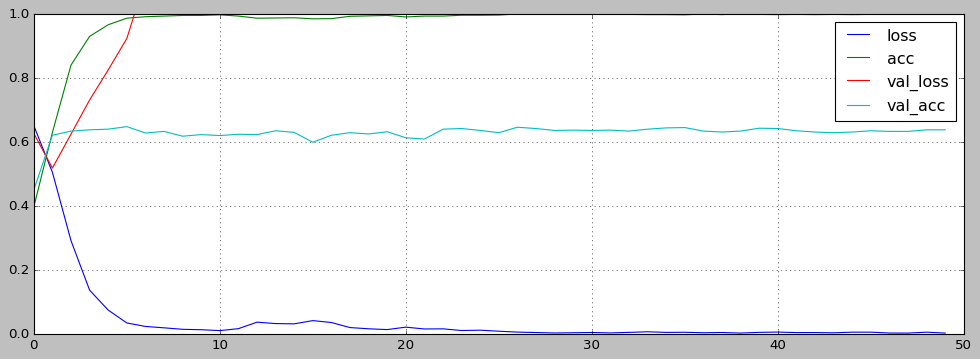

In [25]:
# Visualization
pd.DataFrame(history_training.history).plot(figsize = (15,5))
plt.grid(True)
plt.gca().set_ylim(0,1)

32/32 [==============================] - 5s 13ms/step
              precision    recall  f1-score   support

    positive       0.70      0.64      0.67       358
    negative       0.72      0.66      0.69       323
     neutral       0.52      0.60      0.56       321

    accuracy                           0.64      1002
   macro avg       0.64      0.64      0.64      1002
weighted avg       0.65      0.64      0.64      1002



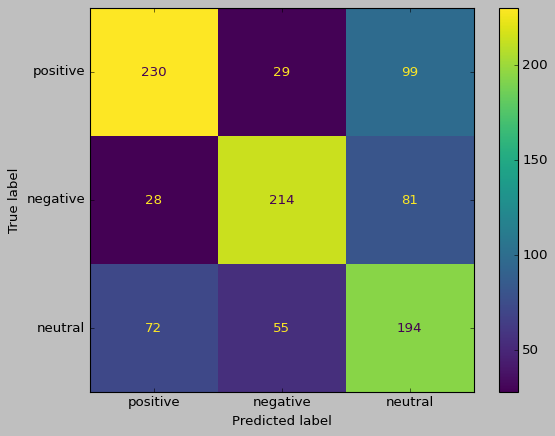

In [26]:
target_names = ['positive',
 'negative',
 'neutral']
# Evaluation
train_loss, train_acc = model.evaluate(train_dataset)
test_loss, test_acc = model.evaluate(test_dataset)

# Prediction
preds = model.predict(test_df.text)
preds = tf.math.argmax(preds, -1)

# Report
report = classification_report(test_df.label_id, preds, target_names=target_names, digits=2)
print(report)
cm = confusion_matrix(test_df.label_id, preds)
_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
_display.plot()
plt.show()

In [35]:
model.save("output/trained_dbgru", save_format='tf')

INFO:tensorflow:Assets written to: output/trained_dbgru\assets


INFO:tensorflow:Assets written to: output/trained_dbgru\assets


In [18]:
sample_text = ["nền kinh tế đang suy giảm"]

sample_text = encoder(np.array(sample_text))
sample_text = tf.squeeze(sample_text, axis=0)

random_preds = model.predict(tf.expand_dims(sample_text, axis=0))
random_preds = tf.math.argmax(random_preds, -1)

lbs = np.unique(np.concatenate([train_df.label_id, test_df.label_id]))
rp = sklearn.metrics.classification_report(test_df.label_id, preds, output_dict=True, label=lbs)
df_rp = pd.DataFrame(report).transpose()
print(df_rp)

ValueError: in user code:

    File "c:\Users\DELL\Programming\python\StockReview.IntroAI.20222\venv\lib\site-packages\keras\engine\training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\DELL\Programming\python\StockReview.IntroAI.20222\venv\lib\site-packages\keras\engine\training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\DELL\Programming\python\StockReview.IntroAI.20222\venv\lib\site-packages\keras\engine\training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\DELL\Programming\python\StockReview.IntroAI.20222\venv\lib\site-packages\keras\engine\training.py", line 2111, in predict_step
        return self(x, training=False)
    File "c:\Users\DELL\Programming\python\StockReview.IntroAI.20222\venv\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\DELL\Programming\python\StockReview.IntroAI.20222\venv\lib\site-packages\keras\layers\preprocessing\text_vectorization.py", line 573, in _preprocess
        raise ValueError(

    ValueError: Exception encountered when calling layer 'text_vectorization' (type TextVectorization).
    
    When using `TextVectorization` to tokenize strings, the input rank must be 1 or the last shape dimension must be 1. Received: inputs.shape=(None, 6) with rank=2
    
    Call arguments received by layer 'text_vectorization' (type TextVectorization):
      • inputs=tf.Tensor(shape=(None, 6), dtype=string)
